In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sc.constants as cs
from sc import payoff as po
from yq.scripts import simulation as yqsm

print(pd.__version__)

first_date = pd.Timestamp('2023-08-09')
last_date = pd.Timestamp('2023-11-09')

total_data = yqsm.read_sim_data('gbm', '20231114_092701_252', first_date, last_date)[0]

2.1.2


In [2]:
# Original product with greeks
# entire pricing window

prices = []
deltas = {'LONN.SE': [], 'SIKA.SE': []}
gammas = {'LONN.SE': [], 'SIKA.SE': []}
for single_day in total_data:
    #rename columns
    df_sim_array = []
    for df in single_day:
        df_sim_array.append(df.rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'}))
    
    results = po.pricing_with_greeks_multiple(df_sim_array, 0.005)
    price_sum = 0
    greeks_sum = {'LONN.SE': [0, 0], 'SIKA.SE': [0, 0]}
    for sim in results:
        price_sum += sim[0]
        for asset in cs.ASSET_NAMES:
            greeks_sum[asset][0] += sim[1][asset][0]
            greeks_sum[asset][1] += sim[1][asset][1]
    est_price = price_sum / len(results)
    for asset in cs.ASSET_NAMES:
        deltas[asset].append(greeks_sum[asset][0] / len(results))
        gammas[asset].append(greeks_sum[asset][1] / len(results))
    prices.append(est_price)

df_product = po.get_product_price(pd.Timestamp('2023-11-09'))
df_product = df_product.loc[first_date : last_date]
df_product['Est_Price'] = prices

df_deltas = pd.DataFrame(index = df_product.index, data = deltas)
df_gammas = pd.DataFrame(index = df_product.index, data = gammas)

In [3]:
# upper bound calculation

df_sim = total_data[0][0]

df_constant = pd.DataFrame(index = df_sim.index, data = {'LONN.SE': [cs.INITIAL_LEVELS['LONN.SE'] * 0.95] * len(df_sim), 'SIKA.SE': [cs.INITIAL_LEVELS['SIKA.SE'] * 0.95] * len(df_sim)})
#print(df_constant)
#display(df_new)
#print(po.payouts(df_new, False))
dict_upper_bound = {}
today = pd.Timestamp('2023-08-09')
for i in range(67):
    df_payouts = po.payouts(df_constant, False)
    dict_upper_bound[today] = po.rnv_single(df_payouts, today)
    today = df_constant.first_valid_index()
    df_constant = df_constant.tail(len(df_constant) - 1)
df_upper_bound = pd.DataFrame.from_dict(dict_upper_bound, orient = 'index')
df_upper_bound.index.name = 'Date'
df_upper_bound.columns = ['Price']
print(df_upper_bound)

                  Price
Date                   
2023-08-09  1060.050752
2023-08-10  1060.112393
2023-08-11  1060.373506
2023-08-14  1060.556219
2023-08-15  1060.816949
...                 ...
2023-11-03  1047.009110
2023-11-06  1047.154525
2023-11-07  1047.202947
2023-11-08  1047.251638
2023-11-09  1047.299751

[67 rows x 1 columns]


In [4]:
# no autocall

def pricing_multiple_no_autocall(df_sim_array):
    first_sim_date = df_sim_array[0].first_valid_index()
    df_historical = po.get_historical_assets(first_sim_date, cs.INITIAL_FIXING_DATE)
    today = df_historical.index[-1]
    barrierHit = po.checkBarrier(df_historical)
    df_payouts_arr = []
    for df_sim in df_sim_array:
        df_payouts = po.payouts_no_autocall(df_sim, barrierHit)
        df_payouts_arr.append(df_payouts)
    rnv_arr = po.rnv_multiple(df_payouts_arr, today)
    return rnv_arr

est_price = []
for single_day in total_data:
    df_sim_array = []
    for df in single_day:
        df_sim_array.append(df.rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'}))
    prices = pricing_multiple_no_autocall(df_sim_array)
    est_price.append(sum(prices) / len(prices))

df_product['Est_Price_No_Autocall'] = est_price

In [5]:
# no barrier (final payoff = denom)
def pricing_multiple_no_barrier_denom(df_sim_array):
    first_sim_date = df_sim_array[0].first_valid_index()
    df_historical = po.get_historical_assets(first_sim_date, cs.INITIAL_FIXING_DATE)
    today = df_historical.index[-1]
    barrierHit = po.checkBarrier(df_historical)
    df_payouts_arr = []
    for df_sim in df_sim_array:
        df_payouts = po.payouts_no_barrier_denom(df_sim, barrierHit)
        df_payouts_arr.append(df_payouts)
    rnv_arr = po.rnv_multiple(df_payouts_arr, today)
    return rnv_arr

est_price = []
for single_day in total_data:
    df_sim_array = []
    for df in single_day:
        df_sim_array.append(df.rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'}))
    prices = pricing_multiple_no_barrier_denom(df_sim_array)
    est_price.append(sum(prices) / len(prices))

df_product['Est_Price_No_Barrier_Denom'] = est_price

In [6]:
#no barrier (final payoff = worst performing)
def pricing_multiple_no_barrier_worst(df_sim_array):
    first_sim_date = df_sim_array[0].first_valid_index()
    df_historical = po.get_historical_assets(first_sim_date, cs.INITIAL_FIXING_DATE)
    today = df_historical.index[-1]
    barrierHit = po.checkBarrier(df_historical)
    df_payouts_arr = []
    for df_sim in df_sim_array:
        df_payouts = po.payouts_no_barrier_worst(df_sim, barrierHit)
        df_payouts_arr.append(df_payouts)
    rnv_arr = po.rnv_multiple(df_payouts_arr, today)
    return rnv_arr

est_price = []
for single_day in total_data:
    df_sim_array = []
    for df in single_day:
        df_sim_array.append(df.rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'}))
    prices = pricing_multiple_no_barrier_worst(df_sim_array)
    est_price.append(sum(prices) / len(prices))

df_product['Est_Price_No_Barrier_Worst'] = est_price

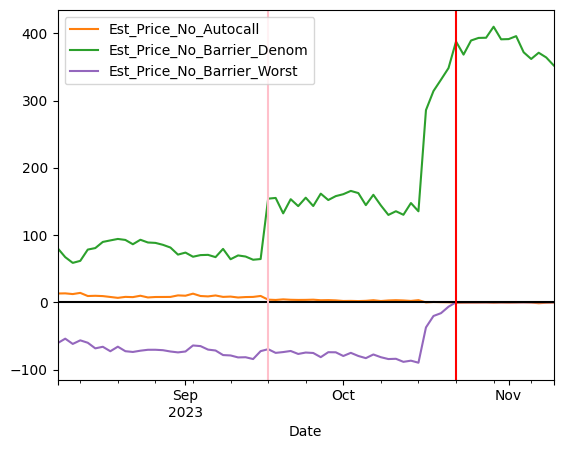

In [7]:
# plots of related products
df_relative = df_product.copy(deep=True)
df_relative['Est_Price_No_Autocall'] = df_relative['Est_Price_No_Autocall'] - df_relative['Est_Price']
df_relative['Est_Price_No_Barrier_Denom'] = df_relative['Est_Price_No_Barrier_Denom'] - df_relative['Est_Price']
df_relative['Est_Price_No_Barrier_Worst'] = df_relative['Est_Price_No_Barrier_Worst'] - df_relative['Est_Price']
df_relative = df_relative.drop(['Est_Price', 'Price'], axis = 1)
plot = df_relative.plot(color = [u'#ff7f0e', u'#2ca02c', u'#9467bd', u'#8c564b', u'#e377c2']).axhline(y=0, color='black')
plt.axvline(x = pd.Timestamp('2023-10-23'), color = 'red')
plt.axvline(x = pd.Timestamp('2023-09-18'), color = 'pink')

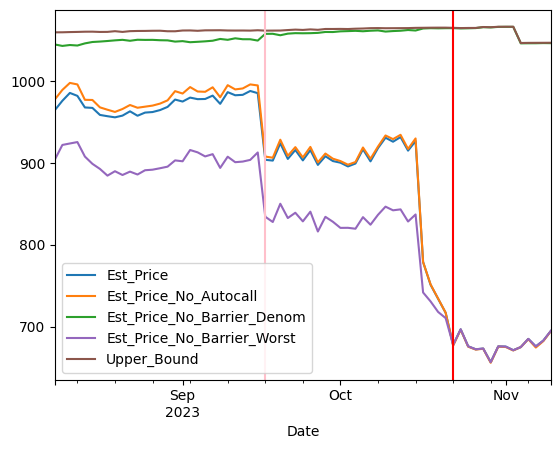

In [8]:
df_est_prices = df_product.drop(['Price'], axis = 1)
df_est_prices['Upper_Bound'] = df_upper_bound['Price']
df_est_prices.plot(color = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#9467bd', u'#8c564b', u'#e377c2']).axvline(x = pd.Timestamp('2023-10-23'), color = 'red')
plt.axvline(x = pd.Timestamp('2023-09-18'), color = 'pink')

<Figure size 1000x600 with 0 Axes>

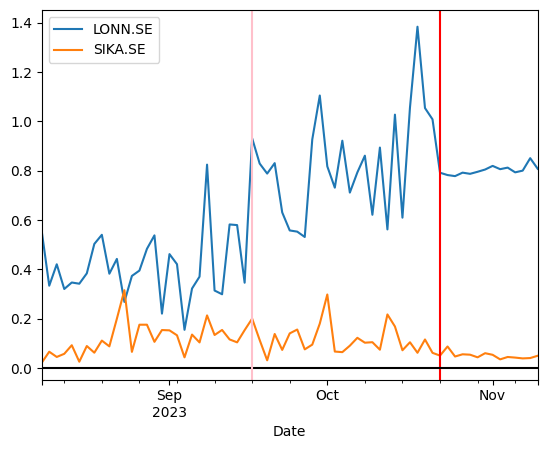

In [9]:
df_deltas = pd.DataFrame(index = df_product.index, data = deltas)

plt.figure(figsize = [10, 6])
df_deltas.plot()
plt.axvline(x = pd.Timestamp('2023-10-23'), color = 'red')
plt.axhline(y = 0, color = 'black')
plt.axvline(x = pd.Timestamp('2023-09-18'), color = 'pink')

<Figure size 1000x600 with 0 Axes>

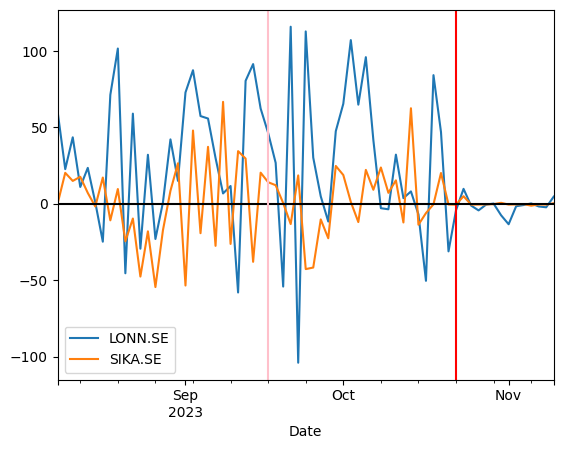

In [10]:
df_gammas = pd.DataFrame(index = df_product.index, data = gammas)

plt.figure(figsize = [10, 6])
df_gammas.plot()
plt.axvline(x = pd.Timestamp('2023-10-23'), color = 'red')
plt.axhline(y = 0, color = 'black')
plt.axvline(x = pd.Timestamp('2023-09-18'), color = 'pink')